In [22]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab
plt.style.use('JFM')

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_data(f):
    dat = np.fromfile(f,sep=' ')
    n = np.size(dat)
    dat = np.reshape(dat,[int(n/6.),6])
    ubar = dat[:,0]
    vbar = dat[:,1]
    utilde = dat[:,2]
    vtilde = dat[:,3]
    ru = dat[:,4]
    rv = dat[:,5]
    return ubar,vbar,utilde,vtilde,ru,rv


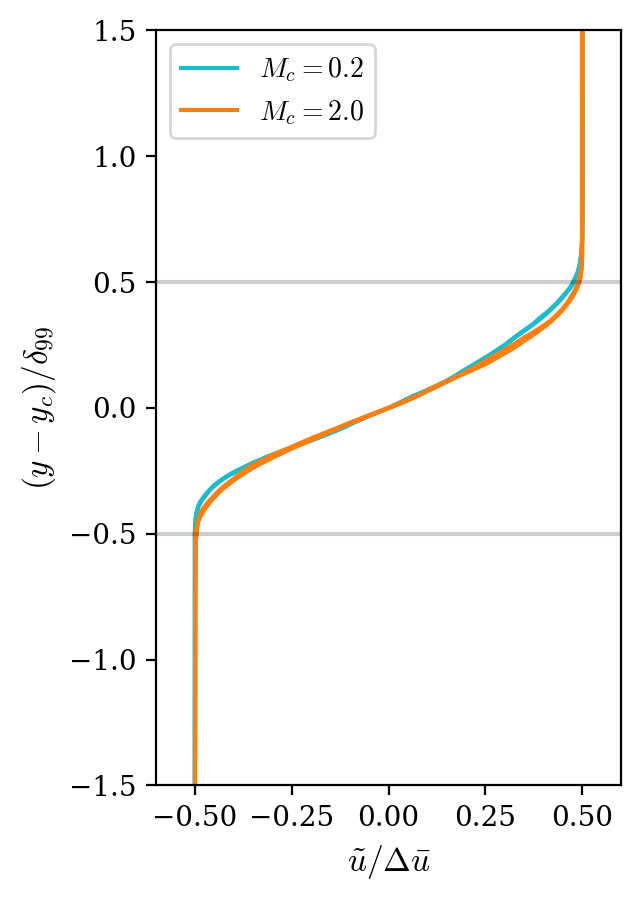

In [24]:
# Mean vel profile

s = '7'
fig = plt.figure(figsize=(3,5),dpi=200)
for Mc in ['02','20']:
    directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"massflux*")
    flist.sort()

    ist=0;ien = -1
    if Mc=='02':colorVal='C9'
    elif Mc=='12':colorVal='C0'
    elif Mc=='20':colorVal='C1'
        
    for j,fname in enumerate(flist[-4:-1]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta
        
        ubar,vbar,utilde,vtilde,ru,rv = get_data(fname)
        if j==0: label=r'$M_c = {}$'.format(inp.Mc)
        else: label=None
            
        L99,i1,i2 = get_L99(-y,utilde)
        ic = np.argmin(abs(utilde))
        eta = (y-y[ic])/L99
        plt.plot(utilde/inp.du,eta,color=colorVal,alpha=1,label=label)

plt.plot([-1,1],[0.5,0.5],'k',alpha=0.2)
plt.plot([-1,1],[-0.5,-0.5],'k',alpha=0.2)
plt.xlim([-0.6,0.6])
plt.ylim([-1.5,1.5])
plt.ylabel(r'$(y-y_c)/\delta_{99}$')
plt.xlabel(r'$\tilde{u}/\Delta\bar{u}$')
plt.legend(fontsize=10)
# plt.grid(True)


('L99=', 11.610228058051135)


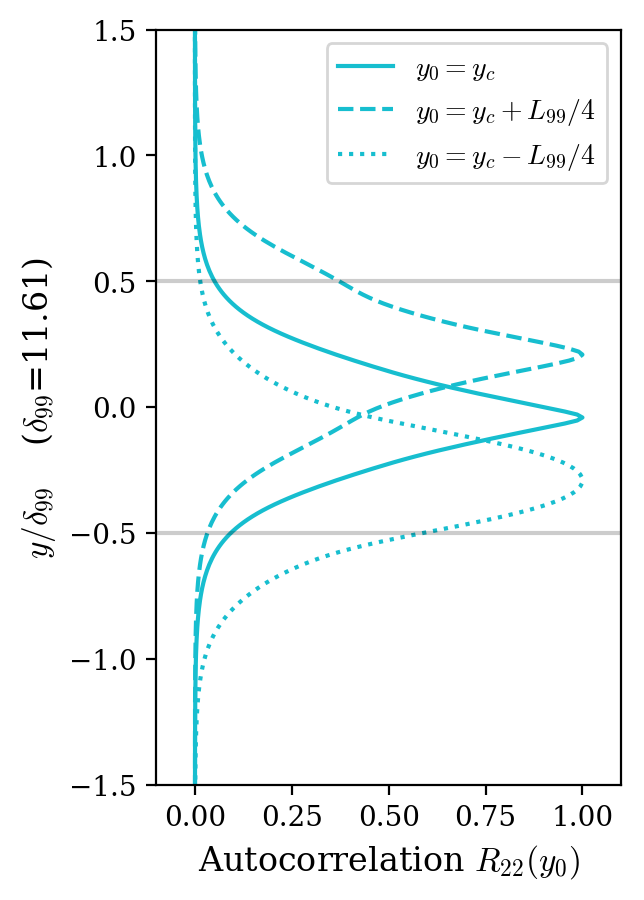

In [3]:
# Decorr lscale profiles
s='7'
for Mc in ['02']:
    directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"lscale_vv*")
    flist.sort()

    if Mc=='02':colorVal='C9'; i1=4; i2=-1
    elif Mc=='12':colorVal='C0'; i1=4; i2=-1
    elif Mc=='20':colorVal='C1'
      
    fig = plt.figure(figsize=(3,5),dpi=200)

    fname=flist[i1]
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)

    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta

    # get utilde
    utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
    L99,i1,i2 = get_L99(-y,utilde)
    eta = y/L99
    print('L99=',L99)
    
    # Get transverse decorr lengthscale
    autocorr = np.fromfile(fname, sep=' ',count=-1)
    autocorr = np.reshape(autocorr,[Ny,3])#[yc,yc+offset,yc-offset]
    plt.plot(autocorr[:,0],eta,'-',color=colorVal,label=r'$y_0=y_c$')
    plt.plot(autocorr[:,1],eta,'--',color=colorVal,label=r'$y_0=y_c+L_{99}/4$')
    plt.plot(autocorr[:,2],eta,':',color=colorVal,label=r'$y_0=y_c-L_{99}/4$')

    plt.xlabel('$\eta$')
    plt.legend()
    plt.plot([-1,2],[0.5,0.5],'k',alpha=0.2)
    plt.plot([-1,2],[-0.5,-0.5],'k',alpha=0.2)
    plt.xlim([-0.1,1.1])
    plt.ylim([-1.5,1.5])
    plt.ylabel(r'$y/\delta_{99}\quad$ ($\delta_{99}$=%0.2f)'%(L99))
    plt.xlabel(r'Autocorrelation $R_{22}(y_0)$')
    plt.legend(fontsize=10)
    
# plt.grid(True)


Text(0.55,0.85,'$\\delta_{99}$=23.7')

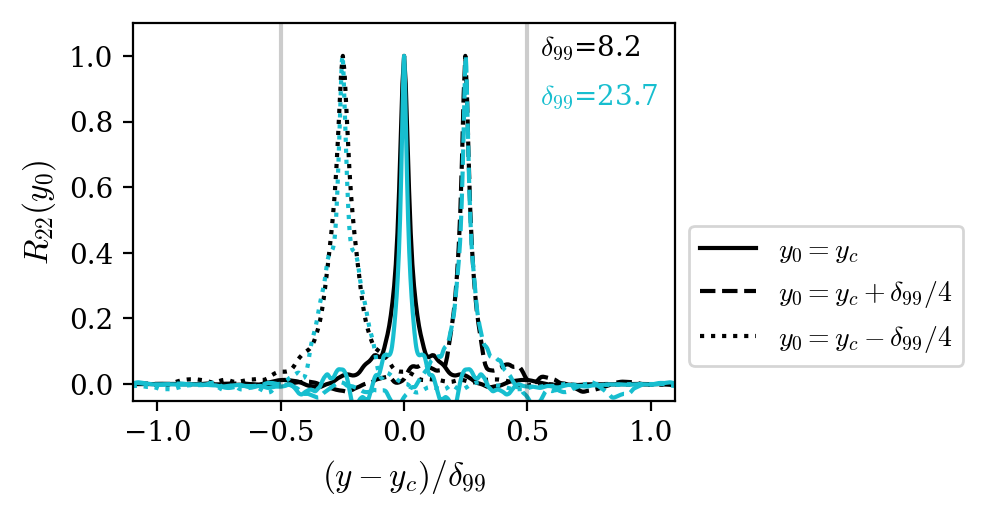

In [21]:
# Decorr lscale profiles

s='7'
for Mc in ['20']:
    directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"lscale_vv*")
    flist.sort()

#     if Mc=='02':colorVal='C9'; i1=4; i2=-1
#     elif Mc=='12':colorVal='C0'; i1=4; i2=-1
#     elif Mc=='20':colorVal='C9'; i1=2; i2=-1
    if Mc=='02':colorVal='C1'; i1=16; i2=-1
    elif Mc=='20':colorVal='C9'; i1=4; i2=-4
      
    fig = plt.figure(figsize=(3.5,2.5),dpi=200)
    L99_list = []
    
    for i in [i1,i2]:
        fname=flist[i]
        tID = fname.split('_')[-1]
        tID = tID.split('.dat')[0]
        time = nml.read_time(directory,tID)

        # get utilde
        utilde = np.fromfile( directory + 'shearlayer_utilde_'+str(tID)+'.dat',sep=' ')
        L99,tmp1,tmp2 = get_L99(-y,utilde)
        ic = np.argmin(abs(utilde))
        eta = (y-y[ic])/L99
        L99_list.append(L99)
    
        # Get transverse decorr lengthscale
        autocorr = np.fromfile(fname, sep=' ',count=-1)
        autocorr = np.reshape(autocorr,[Ny,3])#[yc,yc+offset,yc-offset]
        if i is i1:
            plt.plot(eta,autocorr[:,0],'-',color='k',label=r'$y_0=y_c$')
            plt.plot(eta,autocorr[:,1],'--',color='k',label=r'$y_0=y_c+\delta_{99}/4$')
            plt.plot(eta,autocorr[:,2],':',color='k',label=r'$y_0=y_c-\delta_{99}/4$')
        elif i is i2:
            plt.plot(eta,autocorr[:,0],'-',color=colorVal)
            plt.plot(eta,autocorr[:,1],'--',color=colorVal)
            plt.plot(eta,autocorr[:,2],':',color=colorVal)
        

    plt.xlabel('$\eta$')
    plt.legend()
    plt.plot([0.5,0.5],[-1,2],'k',alpha=0.2)
    plt.plot([-0.5,-0.5],[-1,2],'k',alpha=0.2)
    plt.ylim([-0.05,1.1])
    plt.xlim([-1.1,1.1])
    plt.xlabel(r'$(y-y_c)/\delta_{99}\quad$')
    plt.ylabel(r'$R_{22}(y_0)$')
    plt.legend(fontsize=10,bbox_to_anchor=(1.0,0.5))
plt.annotate(r'$\delta_{99}$=%0.1f'%(L99_list[0]),(.55,1),fontsize=10)
plt.annotate(r'$\delta_{99}$=%0.1f'%(L99_list[1]),(.55,0.85),fontsize=10,color=colorVal)
# plt.annotate('(b)',(-1.05,1),fontsize=10)